In [20]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [21]:
import torch
import torch.backends.cudnn as cudnn
import random
import numpy as np

# seeds
seed = 88
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.deterministic = True
cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [26]:
import torchvision.datasets as datasets
from torchvision.datasets import FGVCAircraft
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset

# remove copyright banner
class RemoveCopyrightBanner(object):
    def __call__(self, img):
        width, height = img.size
        return img.crop((0, 0, width, height - 20))

transform = transforms.Compose([
    # RemoveCopyrightBanner(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# granularity = 'variant'

# # Create the FGVC Aircraft dataset instance
# train_dataset = FGVCAircraft(
#     root='./data',
#     split='trainval',              # Options: 'train', 'val', 'trainval', 'test'
#     annotation_level=granularity,    # Options: 'variant', 'family', 'manufacturer'
#     transform=transform,
#     download=True
# )

data_root = './data'

train_dataset = datasets.DTD(
    root=data_root,
    split='train',
    download=True,
    transform=transform
)

val_dataset = datasets.DTD(
    root=data_root,
    split='val',
    download=True,
    transform=transform
)
test_dataset = datasets.DTD(
    root=data_root,
    split='test',
    download=True,
    transform=transform
)

trainval_dataset = ConcatDataset([train_dataset, val_dataset])
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [0.8, 0.2], generator=g)

# val_dataset = FGVCAircraft(
#     root='./data',
#     split='val',
#     annotation_level='variant',
#     transform=transform,
#     download=True
# )

# test_dataset = FGVCAircraft(
#     root='./data',
#     split='test',
#     annotation_level=granularity,
#     transform=transform,
#     download=True
# )

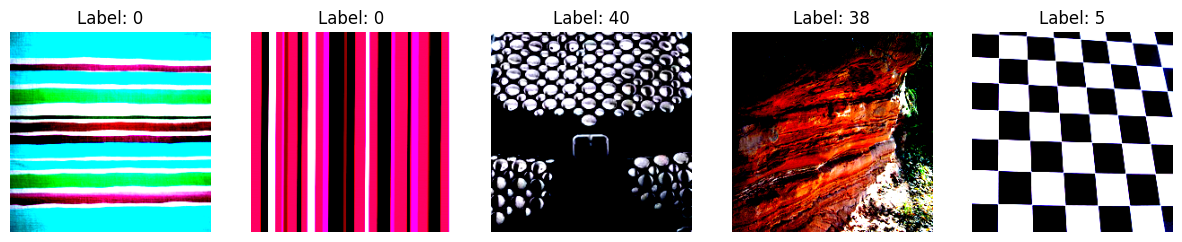

In [13]:
# function to show images
def show_images(train_dataset, num_images=5):
  #shuffle the dataset
  train_dataset = torch.utils.data.Subset(train_dataset, torch.randperm(len(train_dataset)))
  fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
  for i in range(num_images):
      image, label = train_dataset[i]
      image = image.permute(1, 2, 0)  # convert from CxHxW to HxWxC
      axes[i].imshow(image)
      axes[i].set_title(f'Label: {label}')
      axes[i].axis('off')
  plt.show()

show_images(train_dataset, num_images=5)

# Create Dataset

In [14]:
from collections import defaultdict
import torch
from tqdm import tqdm

def group_task_indices(dataset, cumulative=False, max_per_class=1000, classes_per_task=10):
    """
    Task 0: 0-9, Task 1: 10-19, ..., Task 9: 90-99
    Output a dictionary where keys are task indices and values are lists of image indices.
    For example, task_dict[0] will contain indices of images with labels 0-9.
    """
    per_class_counts = defaultdict(int)
    task_dict = defaultdict(list)
    for idx, (_, label) in tqdm(enumerate(dataset), total=len(dataset)):
        # for test and val, should have cumulative indices (all classes seen so far)
        if per_class_counts[label] >= max_per_class:
          continue
        per_class_counts[label] += 1
        if cumulative:
          for i in range((label // classes_per_task), classes_per_task):
            task_dict[i].append(idx)
        else:
          task_dict[label // classes_per_task].append(idx)
    return task_dict

train_task_idxs = group_task_indices(train_dataset, cumulative=False, max_per_class=60)
val_task_idxs = group_task_indices(val_dataset, cumulative=True)
test_task_idxs = group_task_indices(test_dataset, cumulative=True)

100%|██████████| 1880/1880 [00:09<00:00, 204.73it/s]


In [15]:
labels_dict = defaultdict(int)
for i in tqdm(train_task_idxs[0], total=len(train_task_idxs)):
    _, label = train_dataset[i]
    labels_dict[label] += 1
print(labels_dict)

print(f'Total number of tasks: {len(train_task_idxs)}')

599it [00:02, 216.96it/s]

defaultdict(<class 'int'>, {0: 60, 5: 60, 3: 60, 2: 60, 7: 60, 4: 60, 1: 60, 6: 59, 8: 60, 9: 60})
Total number of tasks: 5


## Training Code

In [16]:
def val_net(net_to_val, val_loader):
    net_to_val.eval()
    loss = 0

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for img, label in tqdm(val_loader, desc="Validating"):

            # Get the input images and their corresponding labels
            img, label = img.cuda(), label.cuda()

            # Forward pass: Get predictions from the model
            outputs = net_to_val(img)

            # compute SmoothL1Losss
            loss += criterion(outputs, label)

        return loss / len(val_loader)

def train_net(max_epochs, freeze_epochs, patience, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    net_to_train.cuda()

    initial_freeze = (task == 0) # Only freeze initially for the very first task

    for name, param in net_to_train.named_parameters():
        # do not train non-fc layers
        if initial_freeze and 'fc' not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    optimizer = opt

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"Starting training for Task {task}. Trainable parameters:")
    for name, param in net_to_train.named_parameters():
        if param.requires_grad:
             print(f"  - {name}")


    for epoch in range(max_epochs):
        net_to_train.train()
        running_loss = 0.0

        # Unfreeze logic (if desired for staged training within a task)
        if epoch == freeze_epochs and task > 0: # Only unfreeze/adjust LR if NOT task 0 and freeze_epochs > 0
            print(f"Unfreezing backbone at epoch {epoch} for task {task}")
            for param in net_to_train.parameters():
                param.requires_grad = True
            # Adjust LR for the existing optimizer
            current_lr = optimizer.param_groups[0]['lr']
            new_lr = 1e-4 # Or some other value
            if current_lr != new_lr:
                 print(f"Setting LR to {new_lr}")
                 for g in optimizer.param_groups:
                     g['lr'] = new_lr


        for imgs, labels in tqdm(train_loader, unit='batch', desc=f"Task {task} Epoch {epoch+1}"):
            imgs, labels = imgs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = net_to_train(imgs)
            loss = criterion(outputs, labels) # Loss calculated on combined batch
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # --- Validation (Use Cumulative Loader!) ---
        current_val_loss = val_net(net_to_train, val_loader) # val_loader MUST be cumulative
        val_losses.append(current_val_loss)

        print(f"Task {task}, Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}, Val Loss (Cumulative): {current_val_loss:.4f}")

        # --- Logging to file ---
        if save_file:
             with open(save_file, 'a') as f:
                  f.write(f"{task},{epoch + 1},{avg_loss},{current_val_loss}\n") # Log cumulative val loss

        # --- Early Stopping (Based on CUMULATIVE validation loss) ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            epochs_no_improve = 0
            if save_path: # Optional: save best model state
               torch.save(net_to_train.state_dict(), os.path.join(save_path, f"model_task{task}_best.pth"))
               print(f"  New best validation loss: {best_val_loss:.4f}. Saved best model.")
        else:
            epochs_no_improve += 1
            # print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s). Best: {best_val_loss:.4f}") # Optional verbose print

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1} for task {task}. Best Val Loss: {best_val_loss:.4f}")
            if save_path and os.path.exists(os.path.join(save_path, f"model_task{task}_best.pth")):
               print("Loading best model weights before exiting.")
               net_to_train.load_state_dict(torch.load(os.path.join(save_path, f"model_task{task}_best.pth")))
            break

    print(f"Finished training task {task}")
    return train_losses, val_losses

In [15]:
import torch.nn as nn
def modify_resnet_head(model, num_classes):
  """
  Modify the last fully connected layer of the ResNet model to match the number of classes.
  """

  old_fc = model.fc
  old_num_classes = old_fc.out_features
  num_ftrs = old_fc.in_features

  # Create the new head
  new_fc = nn.Linear(num_ftrs, num_classes).cuda()

  # Copy weights and biases from the old head
  if old_num_classes < num_classes:
    new_fc.weight.data[:old_num_classes, :] = old_fc.weight.data.clone().cuda()
    new_fc.bias.data[:old_num_classes] = old_fc.bias.data.clone().cuda()

  model.fc = new_fc
  return model

In [18]:
import torch

def get_test_accuracy(model, test_loader, num_classes):
    model.eval()
    correct_preds = 0
    total = 0
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing", total=len(test_loader)):
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            preds = output.argmax(dim=1)

            correct_preds += (preds == labels).sum().item()
            total += labels.size(0)

            # Per-class stats
            for c in range(num_classes):
                correct_per_class[c] += ((preds == c) & (labels == c)).sum().item()
                total_per_class[c] += (labels == c).sum().item()

    overall_acc = correct_preds / total
    per_class_acc = [correct_per_class[c] / total_per_class[c] if total_per_class[c] > 0 else 0.0
                     for c in range(num_classes)]
    return overall_acc, per_class_acc


In [ ]:
import random
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import models
import torch.optim as optim

save_dir = 'naive'
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

# Initialize the model
model = models.resnet18(pretrained=True)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

for task in range(5):
    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    # --- Prepare Current Task Dataset ---
    train_loader = DataLoader(
         Subset(train_dataset, train_task_idxs[task]),
        batch_size=128, # Or adjust dynamically
        shuffle=True,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Validation and Test Loaders (Should still be CUMULATIVE!) ---
    val_loader = torch.utils.data.DataLoader(
        Subset(val_dataset, val_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    test_loader = torch.utils.data.DataLoader(
        Subset(test_dataset, test_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Optimizer ---
    # Consider re-initializing or adjusting LR, especially after task 0
    if task == 0:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0015)
    else:
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # Lower LR for full network


    # --- Train the model ---
    # train_net now uses the combined loader
    # No need for EWC parameters here
    train_losses, val_losses = train_net(
        max_epochs=15,
        freeze_epochs=5, # Still relevant if you want staged training
        patience=5,
        net_to_train=model,
        opt=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        task=task,
        save_file=os.path.join(save_dir, 'train_val_losses.txt')
    )


    # --- Evaluate and Save ---
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader, (task+1) * 10)
    print(f"Overall accuracy for task {task} (on classes 0-{(task+1)*10 - 1}): {overall_acc:.4f}")

    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

Training on task 0...
Starting training for Task 0. Trainable parameters:
  - fc.weight
  - fc.bias


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Task 0, Epoch 1, Train Loss: 2.1692, Val Loss (Cumulative): 1.8837


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Task 0, Epoch 2, Train Loss: 1.6433, Val Loss (Cumulative): 1.5152


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Task 0, Epoch 3, Train Loss: 1.2485, Val Loss (Cumulative): 1.2249


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Task 0, Epoch 4, Train Loss: 0.9842, Val Loss (Cumulative): 1.0254


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Task 0, Epoch 5, Train Loss: 0.8019, Val Loss (Cumulative): 0.9055


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Task 0, Epoch 6, Train Loss: 0.6857, Val Loss (Cumulative): 0.8232


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Task 0, Epoch 7, Train Loss: 0.6082, Val Loss (Cumulative): 0.7686


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Task 0, Epoch 8, Train Loss: 0.5363, Val Loss (Cumulative): 0.7255


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Task 0, Epoch 9, Train Loss: 0.4913, Val Loss (Cumulative): 0.6911


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Task 0, Epoch 10, Train Loss: 0.4479, Val Loss (Cumulative): 0.6634


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Task 0, Epoch 11, Train Loss: 0.4240, Val Loss (Cumulative): 0.6584


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Task 0, Epoch 12, Train Loss: 0.3780, Val Loss (Cumulative): 0.6404


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Task 0, Epoch 13, Train Loss: 0.3447, Val Loss (Cumulative): 0.6255


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Task 0, Epoch 14, Train Loss: 0.3308, Val Loss (Cumulative): 0.6060


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Task 0, Epoch 15, Train Loss: 0.3177, Val Loss (Cumulative): 0.5997
Finished training task 0


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


Overall accuracy for task 0 (on classes 0-9): 0.8100
Model for task 0 saved as model_task_0.pth
Training on task 1...
Starting training for Task 1. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.weight
  - layer3.0.bn1.bias
  - layer3.0.conv2.weight
  - layer3.0.b

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Task 1, Epoch 1, Train Loss: 2.3512, Val Loss (Cumulative): 1.8013


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Task 1, Epoch 2, Train Loss: 0.8942, Val Loss (Cumulative): 1.8708


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Task 1, Epoch 3, Train Loss: 0.4002, Val Loss (Cumulative): 2.0263


Task 1 Epoch 4:  20%|██        | 1/5 [00:02<00:11,  2.81s/batch]

In [ ]:
# zip the naive folder
import shutil
shutil.make_archive('naive', 'zip', 'naive')

'/content/naive.zip'

## Replay Code

In [19]:
def train_net(max_epochs, freeze_epochs, patience, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    net_to_train.cuda()

    initial_freeze = (task == 0) # Only freeze initially for the very first task

    for name, param in net_to_train.named_parameters():
        # do not train non-fc layers
        if initial_freeze and 'fc' not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    optimizer = opt

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"Starting training for Task {task}. Trainable parameters:")
    for name, param in net_to_train.named_parameters():
        if param.requires_grad:
             print(f"  - {name}")


    for epoch in range(max_epochs):
        net_to_train.train()
        running_loss = 0.0

        # Unfreeze logic (if desired for staged training within a task)
        if epoch == freeze_epochs and task > 0: # Only unfreeze/adjust LR if NOT task 0 and freeze_epochs > 0
            print(f"Unfreezing backbone at epoch {epoch} for task {task}")
            for param in net_to_train.parameters():
                param.requires_grad = True
            # Adjust LR for the existing optimizer
            current_lr = optimizer.param_groups[0]['lr']
            new_lr = 1e-4 # Or some other value
            if current_lr != new_lr:
                 print(f"Setting LR to {new_lr}")
                 for g in optimizer.param_groups:
                     g['lr'] = new_lr


        for imgs, labels in tqdm(train_loader, unit='batch', desc=f"Task {task} Epoch {epoch+1}"):
            imgs, labels = imgs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = net_to_train(imgs)
            loss = criterion(outputs, labels) # Loss calculated on combined batch
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # --- Validation (Use Cumulative Loader!) ---
        current_val_loss = val_net(net_to_train, val_loader) # val_loader MUST be cumulative
        val_losses.append(current_val_loss)

        print(f"Task {task}, Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}, Val Loss (Cumulative): {current_val_loss:.4f}")

        # --- Logging to file ---
        if save_file:
             with open(save_file, 'a') as f:
                  f.write(f"{task},{epoch + 1},{avg_loss},{current_val_loss}\n") # Log cumulative val loss

        # --- Early Stopping (Based on CUMULATIVE validation loss) ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            epochs_no_improve = 0
            if save_path: # Optional: save best model state
               torch.save(net_to_train.state_dict(), os.path.join(save_path, f"model_task{task}_best.pth"))
               print(f"  New best validation loss: {best_val_loss:.4f}. Saved best model.")
        else:
            epochs_no_improve += 1
            # print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s). Best: {best_val_loss:.4f}") # Optional verbose print

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1} for task {task}. Best Val Loss: {best_val_loss:.4f}")
            if save_path and os.path.exists(os.path.join(save_path, f"model_task{task}_best.pth")):
               print("Loading best model weights before exiting.")
               net_to_train.load_state_dict(torch.load(os.path.join(save_path, f"model_task{task}_best.pth")))
            break

    print(f"Finished training task {task}")
    return train_losses, val_losses

In [ ]:
import random
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import models
import torch.optim as optim


# Initialize the model
model = models.resnet18(pretrained=True)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

# --- Add outside the loop ---
memory_buffer = [] # Simple list to store (image_tensor, label) tuples
memory_size = 1000 # Max number of samples in buffer (hyperparameter)
samples_per_task_in_memory = 20 # How many samples to add from each task (hyperparameter)

def update_memory_buffer(buffer, max_size, new_samples):
    """Adds new samples to the buffer and trims it if it exceeds max_size."""
    buffer.extend(new_samples)
    # If buffer exceeds max size, remove samples randomly (or use FIFO)
    overflow = len(buffer) - max_size
    if overflow > 0:
        # Randomly remove 'overflow' samples
        indices_to_remove = random.sample(range(len(buffer)), overflow)
        # Remove in reverse sorted order to avoid index shifting issues
        for index in sorted(indices_to_remove, reverse=True):
            del buffer[index]
        # Alternatively, for FIFO: del buffer[:overflow]
    print(f"Memory buffer size: {len(buffer)} / {max_size}")

class MemoryDataset(Dataset):
    """A simple Dataset wrapper for the list-based memory buffer."""
    def __init__(self, buffer_list):
        self.buffer = buffer_list

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        # buffer contains (image_tensor, label)
        return self.buffer[idx]

# --- Modify your main loop ---
save_dir = 'replay-coarse-grained' # Changed directory name

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Clear or initialize log files
open(os.path.join(save_dir, 'train_val_losses.txt'), 'w').close()
open(os.path.join(save_dir, 'accuracies.txt'), 'w').write("Task,Overall Accuracy,Per-Class Accuracy\n")


for task in range(5):
    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    # --- Prepare Current Task Dataset ---
    current_task_train_subset = Subset(train_dataset, train_task_idxs[task])

    # --- Prepare Combined Training Loader ---
    if task > 0 and len(memory_buffer) > 0:
        # Create a dataset from the memory buffer
        replay_dataset = MemoryDataset(memory_buffer)
        # Combine current task data and replay data
        combined_train_dataset = ConcatDataset([current_task_train_subset, replay_dataset])
        print(f"Task {task}: Training with {len(current_task_train_subset)} current samples and {len(replay_dataset)} replay samples.")
    else:
        # Task 0 or empty buffer: train only on current task data
        combined_train_dataset = current_task_train_subset
        print(f"Task {task}: Training only with {len(current_task_train_subset)} current samples.")

    # Create DataLoader for the combined dataset
    # Adjust batch size if needed, maybe smaller if memory is large
    train_loader_combined = DataLoader(
        combined_train_dataset,
        batch_size=128, # Or adjust dynamically
        shuffle=True,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Validation and Test Loaders (Should still be CUMULATIVE!) ---
    val_loader_cumulative = torch.utils.data.DataLoader(
        Subset(val_dataset, val_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    test_loader_cumulative = torch.utils.data.DataLoader(
        Subset(test_dataset, test_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Optimizer ---
    # Consider re-initializing or adjusting LR, especially after task 0
    if task == 0:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0015)
    else:
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # Lower LR for full network


    # --- Train the model ---
    # train_net now uses the combined loader
    # No need for EWC parameters here
    train_losses, val_losses = train_net(
        max_epochs=15,
        freeze_epochs=5, # Still relevant if you want staged training
        patience=5,
        net_to_train=model,
        opt=optimizer,
        train_loader=train_loader_combined, # Use the combined loader
        val_loader=val_loader_cumulative, # Use the CUMULATIVE validation loader
        task=task,
        save_file=os.path.join(save_dir, 'train_val_losses.txt')
    )

    # --- Update Memory Buffer AFTER training ---
    # Select samples from the task just finished
    num_to_sample = min(samples_per_task_in_memory, len(current_task_train_subset))
    if num_to_sample > 0:
        indices_to_sample = random.sample(range(len(current_task_train_subset)), num_to_sample)
        new_memory_samples = []
        print(f"Sampling {num_to_sample} examples from task {task} for memory buffer...")
        for idx in indices_to_sample:
            # Get the actual data point (image tensor, label) from the subset
            img_tensor, label = current_task_train_subset[idx]
            new_memory_samples.append((img_tensor, label)) # Append as tuple

        # Add to buffer and manage size
        update_memory_buffer(memory_buffer, memory_size, new_memory_samples)
    else:
        print(f"Not enough samples in task {task} subset to add to memory.")


    # --- Evaluate and Save ---
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader_cumulative, (task+1) * 10)
    print(f"Overall accuracy for task {task} (on classes 0-{(task+1)*10 - 1}): {overall_acc:.4f}")

    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

Training on task 0...
Task 0: Training only with 599 current samples.
Starting training for Task 0. Trainable parameters:
  - fc.weight
  - fc.bias


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Task 0, Epoch 1, Train Loss: 2.2523, Val Loss (Cumulative): 1.9016


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Task 0, Epoch 2, Train Loss: 1.6817, Val Loss (Cumulative): 1.4907


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Task 0, Epoch 3, Train Loss: 1.2804, Val Loss (Cumulative): 1.2332


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Task 0, Epoch 4, Train Loss: 1.0067, Val Loss (Cumulative): 1.0412


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Task 0, Epoch 5, Train Loss: 0.8094, Val Loss (Cumulative): 0.9331


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Task 0, Epoch 6, Train Loss: 0.6994, Val Loss (Cumulative): 0.8546


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Task 0, Epoch 7, Train Loss: 0.6046, Val Loss (Cumulative): 0.7988


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Task 0, Epoch 8, Train Loss: 0.5393, Val Loss (Cumulative): 0.7549


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Task 0, Epoch 9, Train Loss: 0.4877, Val Loss (Cumulative): 0.7192


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Task 0, Epoch 10, Train Loss: 0.4668, Val Loss (Cumulative): 0.6941


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Task 0, Epoch 11, Train Loss: 0.4157, Val Loss (Cumulative): 0.6851


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Task 0, Epoch 12, Train Loss: 0.3813, Val Loss (Cumulative): 0.6689


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Task 0, Epoch 13, Train Loss: 0.3581, Val Loss (Cumulative): 0.6482


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Task 0, Epoch 14, Train Loss: 0.3372, Val Loss (Cumulative): 0.6276


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Task 0, Epoch 15, Train Loss: 0.3099, Val Loss (Cumulative): 0.6239
Finished training task 0
Sampling 20 examples from task 0 for memory buffer...
Memory buffer size: 20 / 1000


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


Overall accuracy for task 0 (on classes 0-9): 0.8075
Model for task 0 saved as model_task_0.pth
Training on task 1...
Task 1: Training with 591 current samples and 20 replay samples.
Starting training for Task 1. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.weig

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Task 1, Epoch 1, Train Loss: 2.1775, Val Loss (Cumulative): 1.8675


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Task 1, Epoch 2, Train Loss: 0.8283, Val Loss (Cumulative): 1.8501


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Task 1, Epoch 3, Train Loss: 0.3740, Val Loss (Cumulative): 1.8384


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


Task 1, Epoch 4, Train Loss: 0.1866, Val Loss (Cumulative): 1.8823


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Task 1, Epoch 5, Train Loss: 0.1043, Val Loss (Cumulative): 1.9572
Unfreezing backbone at epoch 5 for task 1


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


Task 1, Epoch 6, Train Loss: 0.0607, Val Loss (Cumulative): 2.0291


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Task 1, Epoch 7, Train Loss: 0.0366, Val Loss (Cumulative): 2.0641


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


Task 1, Epoch 8, Train Loss: 0.0251, Val Loss (Cumulative): 2.0950
Early stopping triggered at epoch 8 for task 1. Best Val Loss: 1.8384
Finished training task 1
Sampling 20 examples from task 1 for memory buffer...
Memory buffer size: 40 / 1000


Testing: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Overall accuracy for task 1 (on classes 0-19): 0.5038
Model for task 1 saved as model_task_1.pth
Training on task 2...
Task 2: Training with 599 current samples and 40 replay samples.
Starting training for Task 2. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.wei

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Task 2, Epoch 1, Train Loss: 3.5889, Val Loss (Cumulative): 2.4656


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Task 2, Epoch 2, Train Loss: 1.6319, Val Loss (Cumulative): 2.4517


Validating: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


Task 2, Epoch 3, Train Loss: 0.8384, Val Loss (Cumulative): 2.7122


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Task 2, Epoch 4, Train Loss: 0.4767, Val Loss (Cumulative): 2.9067


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Task 2, Epoch 5, Train Loss: 0.2966, Val Loss (Cumulative): 3.0331
Unfreezing backbone at epoch 5 for task 2


Validating: 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


Task 2, Epoch 6, Train Loss: 0.1801, Val Loss (Cumulative): 3.1239


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Task 2, Epoch 7, Train Loss: 0.1097, Val Loss (Cumulative): 3.1994
Early stopping triggered at epoch 7 for task 2. Best Val Loss: 2.4517
Finished training task 2
Sampling 20 examples from task 2 for memory buffer...
Memory buffer size: 60 / 1000


Testing: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Overall accuracy for task 2 (on classes 0-29): 0.3258
Model for task 2 saved as model_task_2.pth
Training on task 3...
Task 3: Training with 596 current samples and 60 replay samples.
Starting training for Task 3. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.wei

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Task 3, Epoch 1, Train Loss: 3.4653, Val Loss (Cumulative): 3.3316


Validating: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Task 3, Epoch 2, Train Loss: 1.6203, Val Loss (Cumulative): 3.2807


Validating: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Task 3, Epoch 3, Train Loss: 0.9532, Val Loss (Cumulative): 3.3314


Validating: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Task 3, Epoch 4, Train Loss: 0.6128, Val Loss (Cumulative): 3.4265


Validating: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Task 3, Epoch 5, Train Loss: 0.4076, Val Loss (Cumulative): 3.5145
Unfreezing backbone at epoch 5 for task 3


Validating: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Task 3, Epoch 6, Train Loss: 0.2926, Val Loss (Cumulative): 3.5714


Validating: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Task 3, Epoch 7, Train Loss: 0.1823, Val Loss (Cumulative): 3.6030
Early stopping triggered at epoch 7 for task 3. Best Val Loss: 3.2807
Finished training task 3
Sampling 20 examples from task 3 for memory buffer...
Memory buffer size: 80 / 1000


Testing: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


Overall accuracy for task 3 (on classes 0-39): 0.2450
Model for task 3 saved as model_task_3.pth
Training on task 4...
Task 4: Training with 419 current samples and 80 replay samples.
Starting training for Task 4. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.wei

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Task 4, Epoch 1, Train Loss: 3.5977, Val Loss (Cumulative): 3.5218


Validating: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


Task 4, Epoch 2, Train Loss: 1.9367, Val Loss (Cumulative): 3.3850


Validating: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Task 4, Epoch 3, Train Loss: 1.0737, Val Loss (Cumulative): 3.4315


Validating: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Task 4, Epoch 4, Train Loss: 0.5872, Val Loss (Cumulative): 3.5276


Validating: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Task 4, Epoch 5, Train Loss: 0.3307, Val Loss (Cumulative): 3.6191
Unfreezing backbone at epoch 5 for task 4


Validating: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


Task 4, Epoch 6, Train Loss: 0.1902, Val Loss (Cumulative): 3.7001


Validating: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


Task 4, Epoch 7, Train Loss: 0.1179, Val Loss (Cumulative): 3.7632
Early stopping triggered at epoch 7 for task 4. Best Val Loss: 3.3850
Finished training task 4
Sampling 20 examples from task 4 for memory buffer...
Memory buffer size: 100 / 1000


Testing: 100%|██████████| 8/8 [00:09<00:00,  1.18s/it]

Overall accuracy for task 4 (on classes 0-49): 0.2053
Model for task 4 saved as model_task_4.pth


In [ ]:
import shutil
shutil.make_archive('replay-coarse-grained', 'zip', 'replay-coarse-grained')

'/content/replay-coardse-grained.zip'

## Confusion Matrix

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


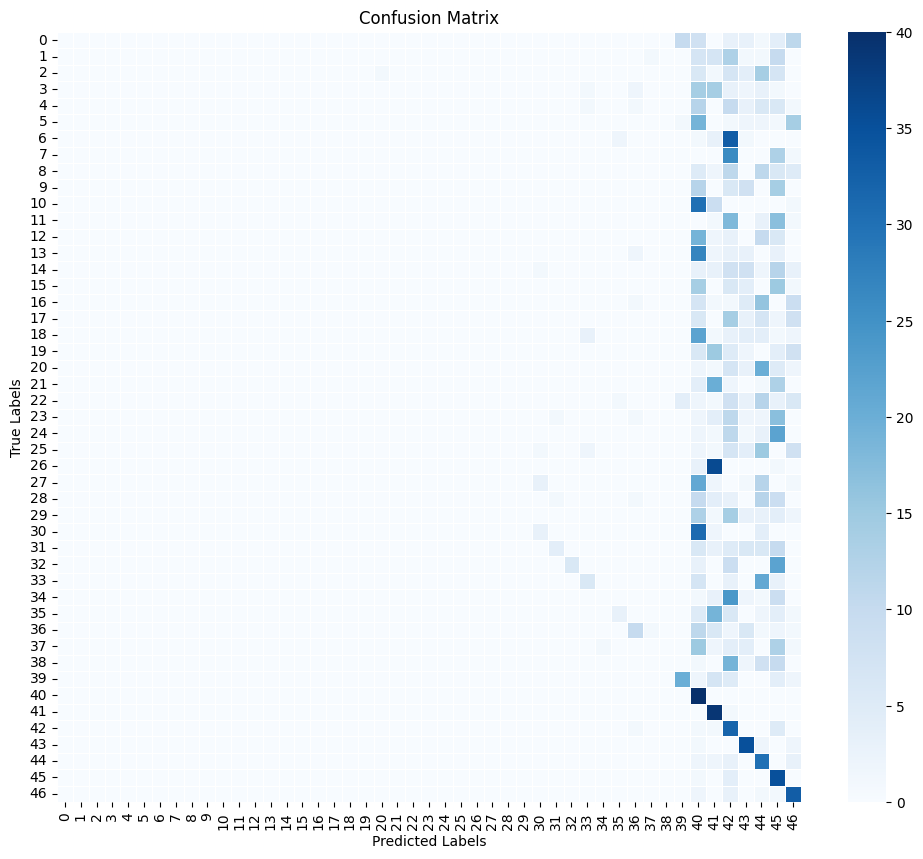

In [28]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import models
import torch.optim as optim

def get_confusion_matrix(model, test_loader, num_classes):
    """
    Computes the confusion matrix for a given model and dataset.

    Args:
        model: The trained model.
        test_loader: The DataLoader for the test dataset.
        num_classes: The number of classes in the dataset.

    Returns:
        A NumPy array representing the confusion matrix.
    """

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Move the with statement here
        for imgs, labels in test_loader:  # Use a for loop for iteration
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            preds = output.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return cm

num_classes = 47

model = models.resnet18(pretrained=True)
modify_resnet_head(model, num_classes)
model.load_state_dict(torch.load("model-naive-DTD.pth"))
model.cuda()

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=g
)

# Get the confusion matrix
cm = get_confusion_matrix(model, test_loader, num_classes)

# --- Display the Confusion Matrix ---
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", linewidths=.5)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## BWT

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import ast
import os

def calculate_and_visualize_bwt(accuracy_file_paths, num_total_classes, num_classes_per_task, dataset_names):
    """
    Calculates Backward Transfer (BWT) from per-class accuracies in multiple text files
    and visualizes them with a grouped bar chart.

    Args:
        accuracy_file_paths: List of paths to the text files containing accuracies.
        num_total_classes: Total number of classes in the dataset.
        num_classes_per_task: Number of classes introduced per task.
        dataset_names: List of dataset names corresponding to the accuracy files.
    """

    num_datasets = len(accuracy_file_paths)
    all_bwt_values = []  # Store BWT values for all datasets

    for file_path in accuracy_file_paths:
        # --- Data Loading and Parsing ---
        parsed_data = {}
        try:
            with open(file_path, 'r') as f:
                header = f.readline().strip()
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        task_id_str, overall_acc_str, per_class_acc_str = line.split(',', 2)
                        task_id = int(task_id_str)
                        per_class_acc_list = ast.literal_eval(per_class_acc_str)
                        parsed_data[task_id] = [float(acc) for acc in per_class_acc_list]
                    except (ValueError, SyntaxError, TypeError) as e:
                        print(f"Warning: Could not parse line. Error: {e}. Line content: '{line}'")
        except FileNotFoundError:
            print(f"Error: Accuracy file not found at '{file_path}'")
            return

        # --- Calculate BWT ---
        bwt_values = []
        for task_id in range(1, len(parsed_data)):
            prev_task_accuracies = parsed_data.get(task_id - 1, [])
            current_task_accuracies = parsed_data.get(task_id, [])

            relevant_classes = len(prev_task_accuracies)
            if relevant_classes > 0:
                initial_performance = np.mean(prev_task_accuracies)
                current_performance = np.mean(current_task_accuracies[:relevant_classes])
                bwt = initial_performance - current_performance
                bwt_values.append(bwt)

        all_bwt_values.append(bwt_values)  # Add BWT values for this dataset

    # --- Visualize with Grouped Bar Chart ---
    num_tasks = len(all_bwt_values[0])  # Number of tasks (assuming all datasets have the same)
    task_labels = [f"Task {i}" for i in range(1, num_tasks + 1)]
    bar_width = 0.8 / num_datasets  # Adjust bar width based on number of datasets
    x_positions = np.arange(num_tasks)

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset_name in enumerate(dataset_names):
        ax.bar(x_positions + i * bar_width, all_bwt_values[i], width=bar_width, label=dataset_name)

    ax.set_xlabel("Task")
    ax.set_ylabel("Backward Transfer (BWT)")
    ax.set_title("Backward Transfer Comparison")
    ax.set_xticks(x_positions + bar_width * (num_datasets -1)/2)  # Center x-axis ticks
    ax.set_xticklabels(task_labels, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

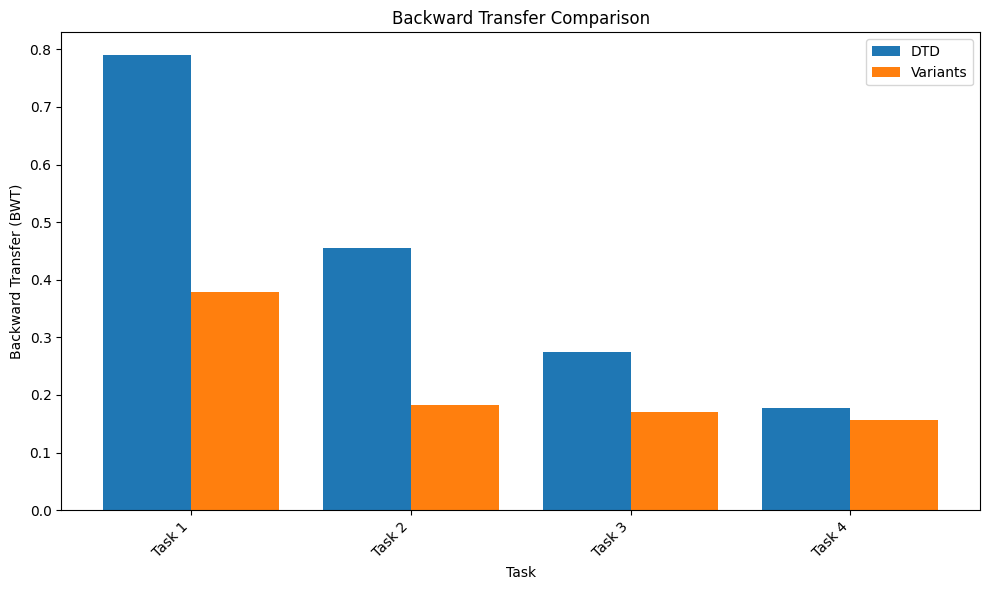

In [13]:
accuracy_file_paths = ['accuracies-DTD-naive.txt', 'accuracies-variants-naive.txt']  # Replace with your file paths
num_total_classes = 50  # Replace with the total number of classes
num_classes_per_task = 10  # Replace with the number of classes per task
dataset_names = ['DTD', 'Variants']  # Replace with your dataset names

calculate_and_visualize_bwt(accuracy_file_paths, num_total_classes, num_classes_per_task, dataset_names)

## Visualizations

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast # To safely evaluate the string list literal
import os # To check if file exists

def viz_acc_drops(accuracy_file_path, num_total_classes, num_classes_per_task, dataset):
  # --- Data Loading and Manual Parsing ---
  parsed_data = {}

  # Check if the file exists before trying to read
  if not os.path.exists(accuracy_file_path):
      print(f"Error: Accuracy file not found at '{accuracy_file_path}'")
      print("Please make sure you have saved the data into a file named 'accuracies.txt' in the correct directory.")
      exit()

  try:
      with open(accuracy_file_path, 'r') as f:
          header = f.readline().strip() # Read and ignore the header line
          if not header.startswith("Task,Overall Accuracy,Per-Class Accuracy"):
              print("Warning: Header doesn't exactly match expected format, but proceeding.")

          for line_num, line in enumerate(f, start=2): # Start line count from 2 for error messages
              line = line.strip()
              if not line: # Skip empty lines
                  continue

              try:
                  # Find the first comma to isolate Task ID
                  first_comma_idx = line.find(',')
                  if first_comma_idx == -1:
                      raise ValueError("Missing first comma separating Task ID")
                  task_id_str = line[:first_comma_idx]
                  task_id = int(task_id_str)

                  # Find the second comma to isolate Overall Accuracy (and the start of the list)
                  # Start searching *after* the first comma
                  second_comma_idx = line.find(',', first_comma_idx + 1)
                  if second_comma_idx == -1:
                      raise ValueError("Missing second comma separating Overall Accuracy")

                  # The rest of the line, starting after the second comma, is the list string
                  list_str = line[second_comma_idx + 1:]

                  # Safely evaluate the string list using ast.literal_eval
                  per_class_acc_list = ast.literal_eval(list_str)

                  # Validate that it's actually a list
                  if not isinstance(per_class_acc_list, list):
                      raise TypeError(f"Parsed data for 'Per-Class Accuracy' is not a list (type: {type(per_class_acc_list)}).")

                  # Convert elements to float just in case
                  per_class_acc_list = [float(acc) for acc in per_class_acc_list]
                  parsed_data[task_id] = per_class_acc_list
                  # print(f"Parsed Task {task_id}, found {len(per_class_acc_list)} accuracies.") # Optional print

              except (ValueError, SyntaxError, TypeError, IndexError) as e:
                  print(f"Warning: Could not parse line {line_num}. Error: {e}. Line content: '{line}'")
              except Exception as e:
                  # Catch any other unexpected errors during parsing of a specific line
                  print(f"An unexpected error occurred parsing line {line_num}: {e}")


  except FileNotFoundError:
      # This case is handled by the os.path.exists check above, but kept for safety
      print(f"Error: Accuracy file not found at '{accuracy_file_path}'")
      exit()
  except Exception as e:
      # Catch errors related to opening or reading the file itself
      print(f"Error reading file '{accuracy_file_path}': {e}")
      exit()

  # --- Prepare Data Matrix for Heatmap (Code remains the same) ---
  num_tasks_found = len(parsed_data)
  if num_tasks_found == 0:
      print("No valid task data parsed. Exiting.")
      exit()

  # Create a matrix: rows = tasks, cols = classes
  # Initialize with NaN for classes not yet seen/evaluated
  acc_matrix = np.full((num_tasks_found, num_total_classes), np.nan)

  sorted_task_ids = sorted(parsed_data.keys())

  for task_idx, task_id in enumerate(sorted_task_ids):
      accuracies = parsed_data[task_id]
      num_classes_in_task_eval = len(accuracies)
      if num_classes_in_task_eval > num_total_classes:
          print(f"Warning: Task {task_id} reported {num_classes_in_task_eval} accuracies, exceeding total classes {num_total_classes}. Truncating.")
          num_classes_in_task_eval = num_total_classes
          accuracies = accuracies[:num_total_classes]

      # Fill the matrix row for this task up to the number of classes evaluated
      acc_matrix[task_idx, :num_classes_in_task_eval] = accuracies

  # --- Plotting the Heatmap (Code remains the same) ---
  plt.figure(figsize=(20, max(5, num_tasks_found * 0.7))) # Adjusted size

  heatmap = sns.heatmap(
      acc_matrix,
      annot=False,
      fmt=".2f",
      cmap="viridis",
      linewidths=0.2,
      linecolor='lightgrey',
      cbar_kws={'label': 'Per-Class Accuracy'},
      vmin=0.0,
      vmax=1.0
  )

  plt.xlabel("Class ID")
  plt.ylabel("Evaluation Point (After Task X Completed)")
  plt.title(f"Per-Class Accuracy After Each Task - {dataset}", fontsize=16)
  plt.xticks(ticks=np.arange(0, num_total_classes, 5) + 0.5, labels=np.arange(0, num_total_classes, 5), rotation=90, fontsize=8)
  plt.yticks(ticks=np.arange(num_tasks_found) + 0.5, labels=[f"After Task {t}" for t in sorted_task_ids], rotation=0)

  for i in range(num_classes_per_task, num_total_classes, num_classes_per_task):
      plt.axvline(x=i, color='white', linestyle='--', linewidth=1.0)

  plt.tight_layout()
  plt.show()

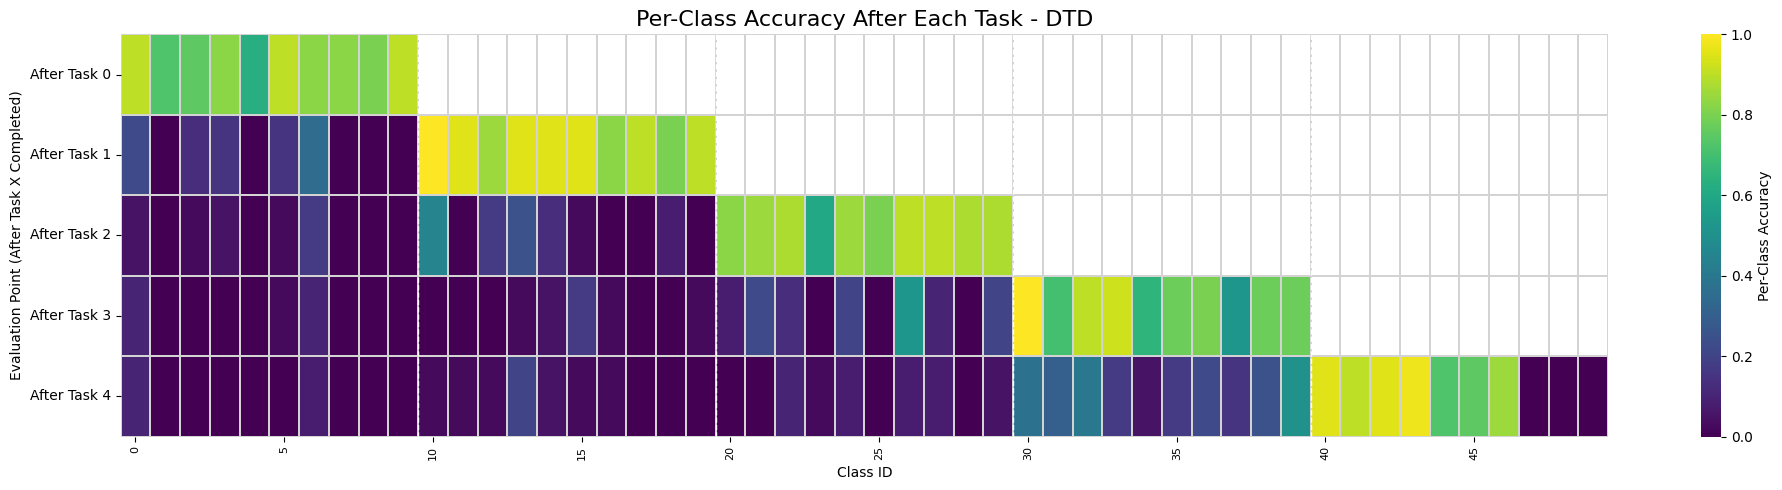

In [ ]:
# texture dataset
accuracy_file_path = 'accuracies-DTD.txt' # Make sure this file exists
num_total_classes = 50
num_classes_per_task = 10

viz_acc_drops(accuracy_file_path, num_total_classes, num_classes_per_task, 'DTD')

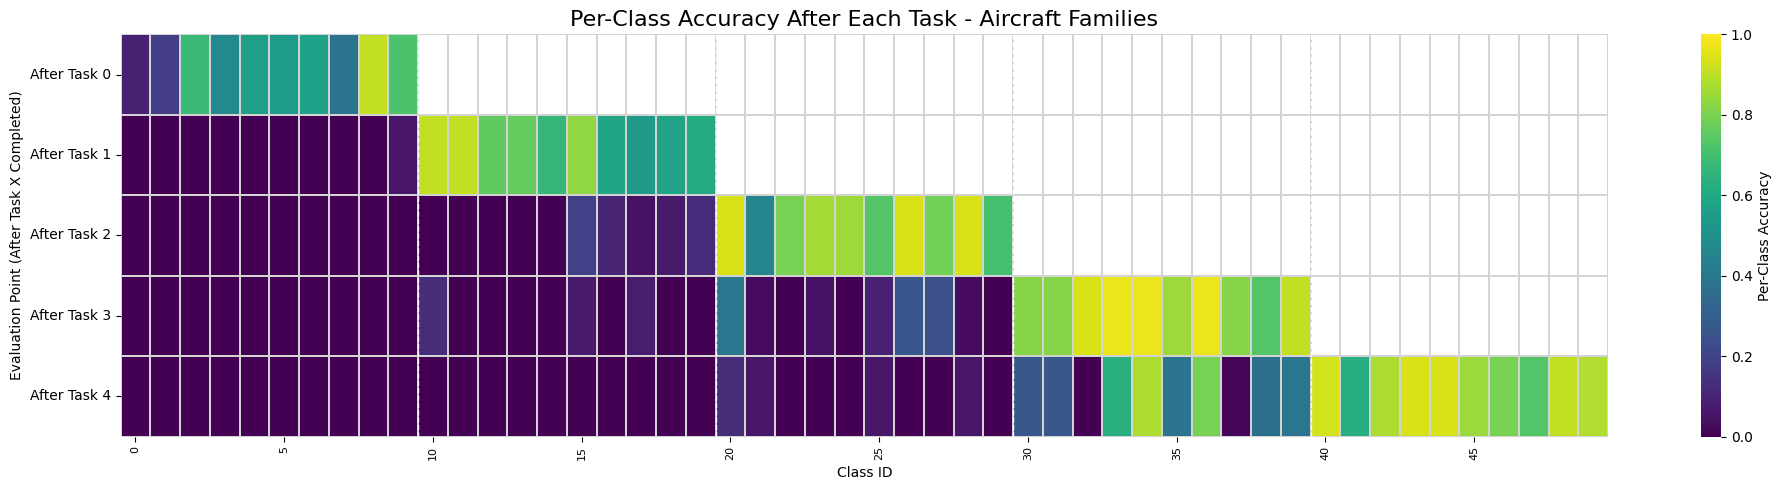

In [ ]:
# the aircraft families
accuracy_file_path = 'accuracies-families.txt'
num_total_classes = 50
num_classes_per_task = 10

viz_acc_drops(accuracy_file_path, num_total_classes, num_classes_per_task, 'Aircraft Families')

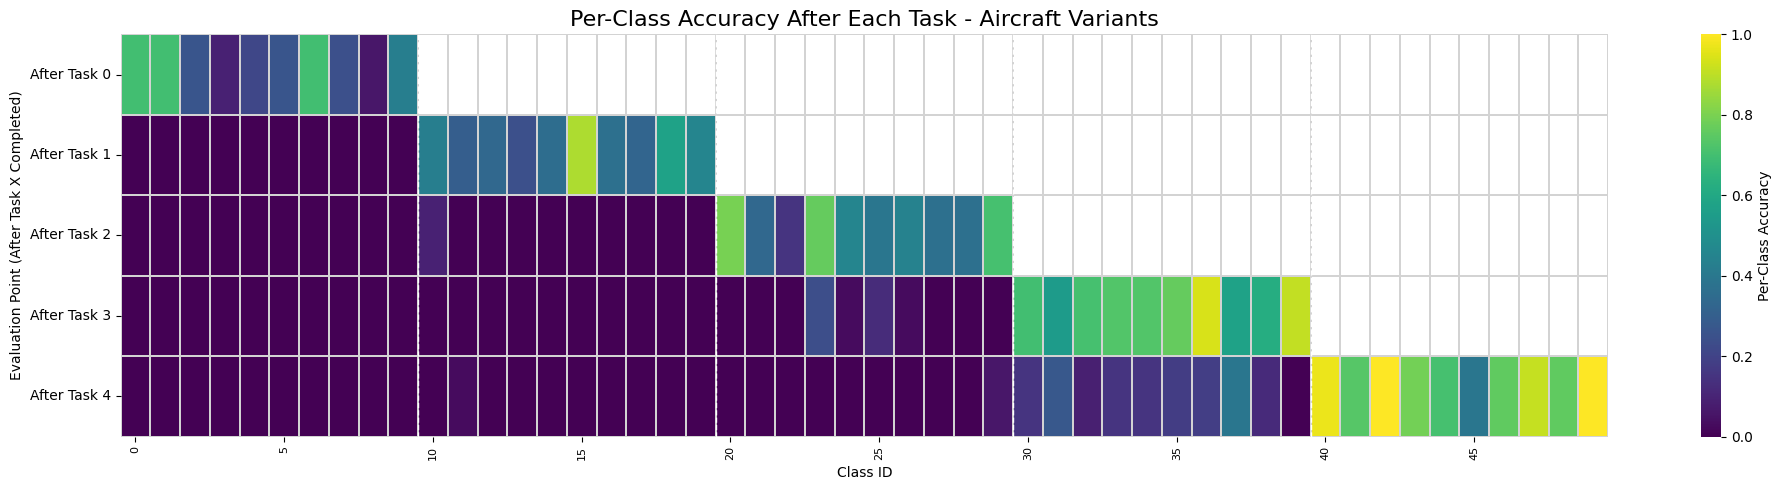

In [ ]:
# the aircraft variants
accuracy_file_path = 'accuracies-variants.txt'
num_total_classes = 50
num_classes_per_task = 10

viz_acc_drops(accuracy_file_path, num_total_classes, num_classes_per_task, 'Aircraft Variants')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

def viz_forgetting_measure(filepath, dataset):
  """
  Forgetting for a previous task i after learning task t is:
  max_accuracy(task i) - current_accuracy(task i).
  The average forgetting after task t is the average of this
  value across all tasks i < t.
  """
  data = []
  with open(filepath, 'r') as f:
      header = next(f) # Read header
      for line in f:
          parts = line.strip().split(',', 2) # Split only twice
          if len(parts) == 3:
              task = int(parts[0])
              overall_acc = float(parts[1])
              # Safely parse the string representation of the list
              per_class_str = parts[2]
              per_class_list = ast.literal_eval(per_class_str)
              data.append({
                  'Task': task,
                  'Overall Accuracy': overall_acc,
                  'Per-Class Accuracy': per_class_list
              })

  df = pd.DataFrame(data)
  # --- Determine classes per task ---
  num_tasks = len(df)
  classes_per_task = []
  cumulative_classes = 0
  class_indices_per_task = {} # Dictionary to store class indices for each task
  for i in range(num_tasks):
      current_total_classes = len(df.loc[i, 'Per-Class Accuracy'])
      num_new_classes = current_total_classes - cumulative_classes
      classes_per_task.append(num_new_classes)
      task_class_indices = list(range(cumulative_classes, current_total_classes))
      class_indices_per_task[i] = task_class_indices
      cumulative_classes = current_total_classes

  print(f"Detected {num_tasks} tasks.")
  print(f"Classes introduced per task: {classes_per_task}")
  print(f"Class indices per task: {class_indices_per_task}")

  # --- Calculate peak accuracy for each task ---
  # (Average accuracy on its classes right after it was learned)
  peak_task_accuracies = {}
  for i in range(num_tasks):
      task_class_indices = class_indices_per_task.get(i, [])
      # Get accuracies evaluated right after task i
      accuracies_at_eval_i = df.loc[i, 'Per-Class Accuracy']
      # Extract accuracies ONLY for classes belonging to task i
      task_i_class_accuracies = [accuracies_at_eval_i[idx] for idx in task_class_indices]
      peak_task_accuracies[i] = np.mean(task_i_class_accuracies)

  print(f"Peak average accuracy per task (Acc(i,i)): {peak_task_accuracies}")

  # --- Calculate Average Forgetting ---
  average_forgetting = []
  evaluation_points = [] # Tasks after which forgetting is measured (1 to T)

  for t in range(1, num_tasks): # Evaluate forgetting AFTER task t (t=1 to num_tasks-1)
      total_forgetting_at_t = 0.0
      num_previous_tasks_measured = 0

      # Get accuracies evaluated after task t
      accuracies_at_eval_t = df.loc[t, 'Per-Class Accuracy']

      for i in range(t): # Iterate through all tasks learned *before* t (i=0 to t-1)
        task_i_class_indices = class_indices_per_task.get(i, [])

        # Extract accuracies for task i's classes measured after task t
        task_i_accuracies_at_t = [accuracies_at_eval_t[idx] for idx in task_i_class_indices]
        current_acc_i_at_t = np.mean(task_i_accuracies_at_t)
        peak_acc_i = peak_task_accuracies.get(i, 0) # Get peak accuracy for task i

        # Calculate forgetting for task i
        forgetting_i_at_t = max(0, peak_acc_i - current_acc_i_at_t) # Ensure non-negative
        total_forgetting_at_t += forgetting_i_at_t
        num_previous_tasks_measured += 1

      avg_forgetting_t = total_forgetting_at_t / num_previous_tasks_measured
      average_forgetting.append(avg_forgetting_t)
      evaluation_points.append(t) # Record the task number after which this avg forgetting was calculated
  print(f"\nAverage Forgetting after each task {evaluation_points}: {average_forgetting}")

  # --- Plotting ---
  plt.figure(figsize=(8, 5))
  plt.plot(evaluation_points, average_forgetting, marker='o', linestyle='-')
  plt.xlabel("Task Number Completed (Evaluation Point)")
  plt.ylabel("Average Forgetting")
  plt.title(f"Average Forgetting vs. Number of Tasks Completed - {dataset}")
  plt.xticks(evaluation_points) # Ensure ticks are at the actual task numbers
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.ylim(bottom=0) # Forgetting cannot be negative
  plt.show()

Detected 5 tasks.
Classes introduced per task: [10, 10, 10, 10, 10]
Class indices per task: {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 3: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 4: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]}
Peak average accuracy per task (Acc(i,i)): {0: np.float64(0.36488413547237075), 1: np.float64(0.424331550802139), 2: np.float64(0.47664884135472374), 3: np.float64(0.7209447415329768), 4: np.float64(0.8019607843137255)}

Average Forgetting after each task [1, 2, 3, 4]: [np.float64(0.36488413547237075), np.float64(0.3900623885918003), np.float64(0.40808080808080804), np.float64(0.4523618538324421)]


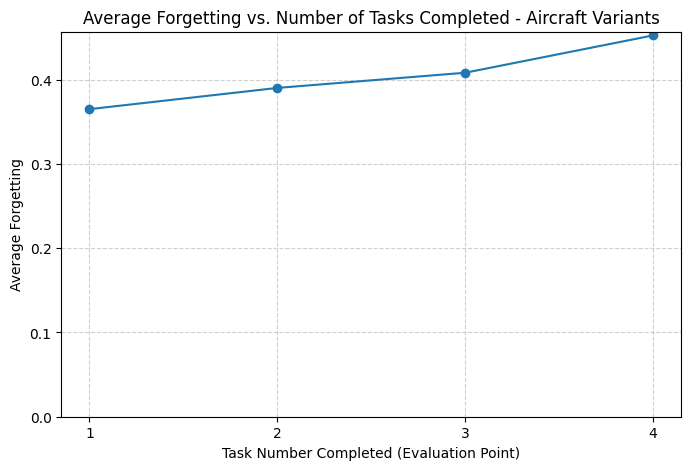

Detected 5 tasks.
Classes introduced per task: [10, 10, 10, 10, 10]
Class indices per task: {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 3: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 4: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]}
Peak average accuracy per task (Acc(i,i)): {0: np.float64(0.5110304094500758), 1: np.float64(0.7158056014043364), 2: np.float64(0.8005360896054488), 3: np.float64(0.8795008912655972), 4: np.float64(0.8477543033495623)}

Average Forgetting after each task [1, 2, 3, 4]: [np.float64(0.5050602601963445), np.float64(0.5872712703604599), np.float64(0.6302825412542176), np.float64(0.6188973923163912)]


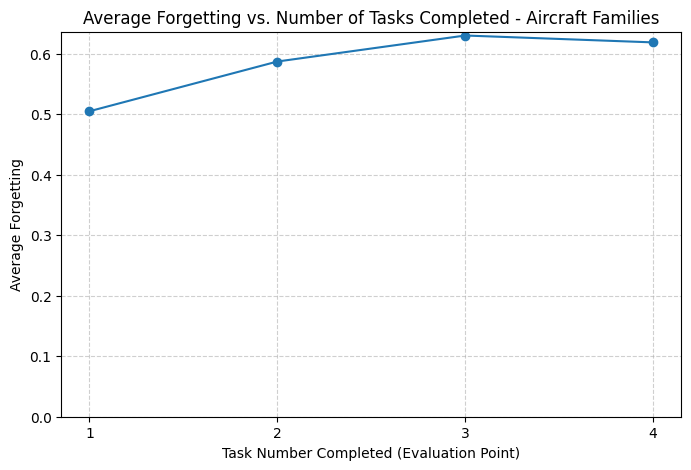

Detected 5 tasks.
Classes introduced per task: [10, 10, 10, 10, 10]
Class indices per task: {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 3: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 4: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]}
Peak average accuracy per task (Acc(i,i)): {0: np.float64(0.8074999999999999), 1: np.float64(0.9075000000000001), 2: np.float64(0.835), 3: np.float64(0.7825000000000001), 4: np.float64(0.61)}

Average Forgetting after each task [1, 2, 3, 4]: [np.float64(0.7074999999999999), np.float64(0.78625), np.float64(0.7841666666666667), np.float64(0.744375)]


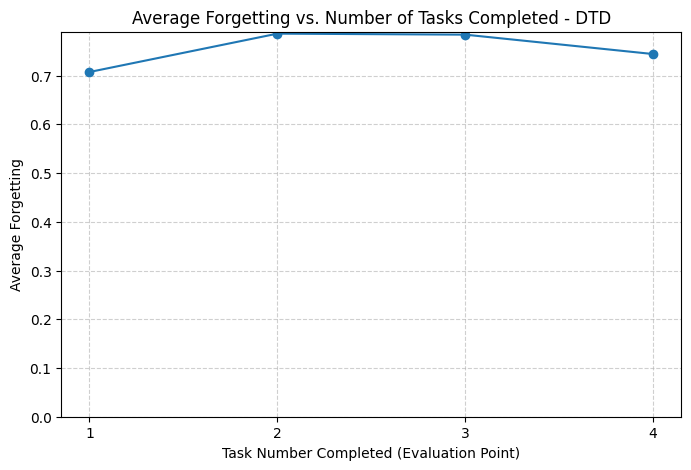

In [ ]:
# forgetting measure for texture dataset
viz_forgetting_measure('accuracies-variants.txt', 'Aircraft Variants')
# forgetting measure for families
viz_forgetting_measure('accuracies-families.txt', 'Aircraft Families')
# forgetting measure for variants
viz_forgetting_measure('accuracies-DTD.txt', 'DTD')

In [ ]:
# using relative forgetting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

def viz_relative_forgetting_measure(filepath, dataset):
  """
  Calculates and visualizes the Average Relative Forgetting.

  Relative Forgetting for a previous task i after learning task t is:
  (max_accuracy(task i) - current_accuracy(task i)) / max_accuracy(task i).
  If max_accuracy(task i) is 0, relative forgetting is 0.
  Ensures the value is non-negative.

  The average relative forgetting after task t is the average of this
  value across all tasks i < t.
  """
  data = []
  with open(filepath, 'r') as f:
    header = next(f) # Read header
    for line_num, line in enumerate(f, start=2):
      line = line.strip()
      parts = line.strip().split(',', 2) # Split only twice
      if len(parts) == 3:
        task = int(parts[0])
        overall_acc = float(parts[1])
        # Safely parse the string representation of the list
        per_class_str = parts[2]
        per_class_list = ast.literal_eval(per_class_str)
        if not isinstance(per_class_list, list):
          raise TypeError("Parsed per-class accuracy is not a list.")
        data.append({
            'Task': task,
            'Overall Accuracy': overall_acc,
            'Per-Class Accuracy': [float(acc) for acc in per_class_list] # Ensure float
        })

  df = pd.DataFrame(data)
  df = df.sort_values(by='Task').reset_index(drop=True) # Ensure tasks are sorted
  num_tasks = len(df)

  # --- Determine classes per task ---
  classes_per_task = []
  cumulative_classes = 0
  class_indices_per_task = {} # Dictionary to store class indices for each task
  for i in range(num_tasks):
      # Ensure Per-Class Accuracy exists and is a list for this task index
      current_total_classes = len(df.loc[i, 'Per-Class Accuracy'])
      num_new_classes = current_total_classes - cumulative_classes
      classes_per_task.append(num_new_classes)
      task_class_indices = list(range(cumulative_classes, current_total_classes))
      class_indices_per_task[i] = task_class_indices
      cumulative_classes = current_total_classes


  print(f"Detected {num_tasks} tasks.")
  print(f"Classes introduced per task: {classes_per_task}")
  # print(f"Class indices per task: {class_indices_per_task}") # Less crucial to print

  # --- Calculate peak accuracy for each task ---
  peak_task_accuracies = {}
  for i in range(num_tasks):
    task_class_indices = class_indices_per_task.get(i, [])
    # Get accuracies evaluated right after task i
    accuracies_at_eval_i = df.loc[i, 'Per-Class Accuracy']

    # Extract accuracies ONLY for classes belonging to task i
    task_i_class_accuracies = [accuracies_at_eval_i[idx] for idx in task_class_indices]
    peak_task_accuracies[i] = np.mean(task_i_class_accuracies) # store the average of accuracies for the 10 classes belonging to this task


  print(f"Peak average accuracy per task (Acc(i,i)): {peak_task_accuracies}")

  # --- Calculate Average Relative Forgetting ---
  average_relative_forgetting = []
  evaluation_points = [] # Tasks after which forgetting is measured (1 to T-1)

  for t in range(1, num_tasks): # Evaluate forgetting AFTER task t (t=1 to num_tasks-1)
      total_relative_forgetting_at_t = 0.0
      num_previous_tasks_measured = 0

      # Get accuracies evaluated after task t
      accuracies_at_eval_t = df.loc[t, 'Per-Class Accuracy']
      len_accuracies_at_eval_t = len(accuracies_at_eval_t)

      for i in range(t): # Iterate through all tasks learned *before* t (i=0 to t-1)
        task_i_class_indices = class_indices_per_task.get(i, [])

        # Extract accuracies for task i's classes measured after task t
        task_i_accuracies_at_t = [accuracies_at_eval_t[idx] for idx in task_i_class_indices]
        current_acc_i_at_t = np.mean(task_i_accuracies_at_t) if task_i_accuracies_at_t else 0.0

        peak_acc_i = peak_task_accuracies.get(i, 0) # Get peak accuracy for task i

        # <<< Calculate RELATIVE forgetting for task i >>>
        if peak_acc_i > 1e-6: # Use a small threshold instead of exact 0 for float comparison
            relative_forgetting_i_at_t = (peak_acc_i - current_acc_i_at_t) / peak_acc_i
        else:
            # If peak accuracy was effectively 0, relative forgetting is 0
            relative_forgetting_i_at_t = 0.0

        # Ensure non-negative relative forgetting
        relative_forgetting_i_at_t = max(0, relative_forgetting_i_at_t)

        total_relative_forgetting_at_t += relative_forgetting_i_at_t
        num_previous_tasks_measured += 1

      # Avoid division by zero if no previous tasks could be measured (e.g., due to index errors)
      if num_previous_tasks_measured > 0:
          avg_relative_forgetting_t = total_relative_forgetting_at_t / num_previous_tasks_measured
          average_relative_forgetting.append(avg_relative_forgetting_t)
          evaluation_points.append(t + 1) # Record the task number *after which* this avg forgetting was calculated (Task 1 completed -> Eval point 1, Task 2 completed -> Eval point 2 etc.)
      else:
           print(f"Warning: No previous tasks could be measured for forgetting after task {t}.")


  # Adjust evaluation points if needed - the loop calculates forgetting *after* task t (where t goes from 1 to num_tasks-1)
  # So evaluation_points naturally correspond to the number of tasks completed.
  # E.g., when t=1, we measure after task 1; when t=num_tasks-1, we measure after task num_tasks-1.
  # Let's adjust the x-axis label to be clearer.
  evaluation_points_xaxis = [pt for pt in range(1, num_tasks)] # Should match len(average_relative_forgetting)
  print(f"\nAverage Relative Forgetting after tasks {evaluation_points_xaxis}: {average_relative_forgetting}")


  # --- Plotting ---
  plt.figure(figsize=(8, 5))
  # Ensure we plot the correct number of points
  if len(evaluation_points_xaxis) == len(average_relative_forgetting):
      plt.plot(evaluation_points_xaxis, average_relative_forgetting, marker='o', linestyle='-')
      plt.xlabel("Task Number Completed (Evaluation Point)") # Label clarified
      plt.ylabel("Average Relative Forgetting") # Updated Label
      plt.title(f"Average Relative Forgetting vs. Number of Tasks Completed - {dataset}") # Updated Title
      plt.xticks(evaluation_points_xaxis) # Ensure ticks are at the actual task numbers
      plt.grid(True, linestyle='--', alpha=0.6)
      plt.ylim(bottom=0, top=1.05) # Relative forgetting is typically 0-1, add slight margin
      plt.show()
  else:
      print("Error: Mismatch between evaluation points and calculated forgetting values. Cannot plot.")

Detected 5 tasks.
Classes introduced per task: [10, 10, 10, 10, 10]
Peak average accuracy per task (Acc(i,i)): {0: np.float64(0.8074999999999999), 1: np.float64(0.9075000000000001), 2: np.float64(0.835), 3: np.float64(0.7825000000000001), 4: np.float64(0.61)}

Average Relative Forgetting after tasks [1, 2, 3, 4]: [np.float64(0.8761609907120743), np.float64(0.9192701003846515), np.float64(0.9218085590199229), np.float64(0.8892083242753078)]


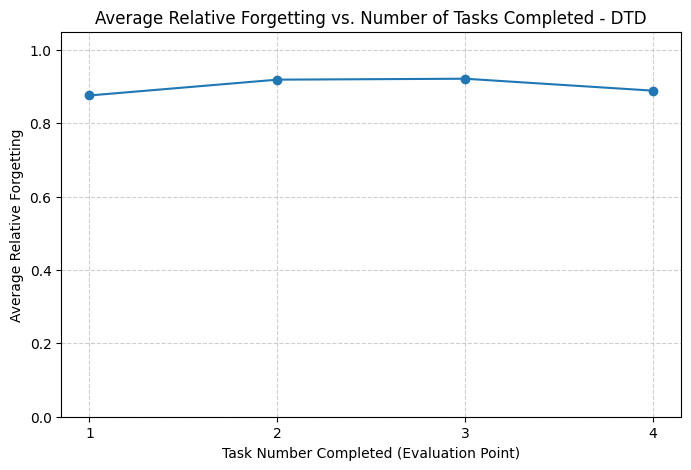

In [ ]:
viz_relative_forgetting_measure('accuracies-DTD.txt', 'DTD')

Detected 3 tasks.
Classes introduced per task: [10, 10, 10]
Peak average accuracy per task (Acc(i,i)): {0: np.float64(0.5168145870619059), 1: np.float64(0.8324242171319896), 2: np.float64(0.848686692976024)}

Average Relative Forgetting after tasks [1, 2]: [np.float64(0.8918715641157344), np.float64(0.9422648633996655)]


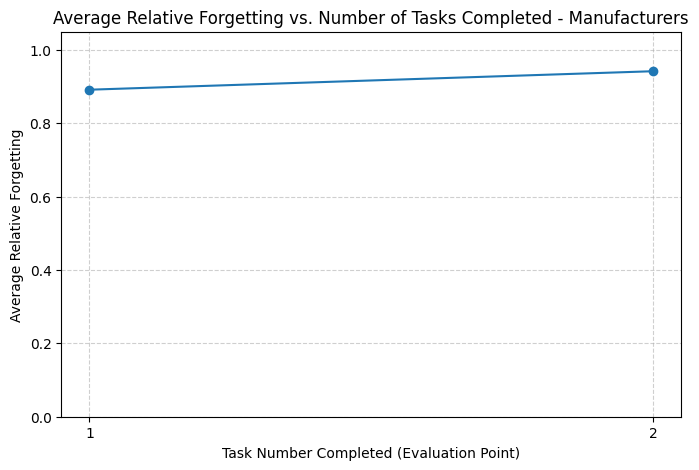

In [ ]:
viz_relative_forgetting_measure('accuracies-manu.txt', 'Manufacturers')

Detected 5 tasks.
Classes introduced per task: [10, 10, 10, 10, 10]
Peak average accuracy per task (Acc(i,i)): {0: np.float64(0.5110304094500758), 1: np.float64(0.7158056014043364), 2: np.float64(0.8005360896054488), 3: np.float64(0.8795008912655972), 4: np.float64(0.8477543033495623)}

Average Relative Forgetting after tasks [1, 2, 3, 4]: [np.float64(0.9883174285848159), np.float64(0.9634722960878638), np.float64(0.9418553617181366), np.float64(0.8765571147451513)]


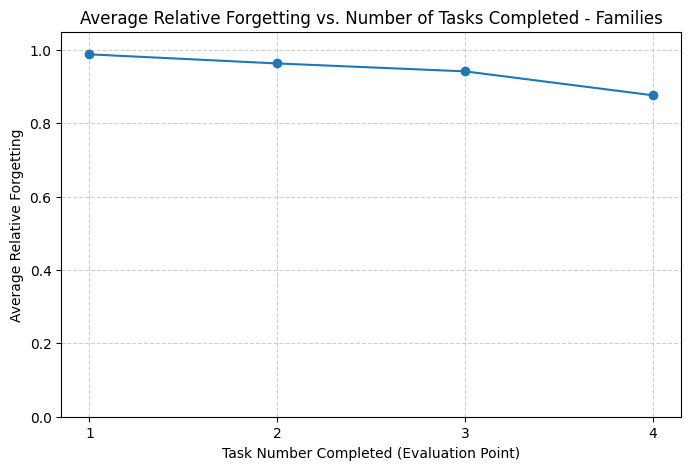

In [ ]:
viz_relative_forgetting_measure('accuracies-families.txt', 'Families')

Detected 5 tasks.
Classes introduced per task: [10, 10, 10, 10, 10]
Peak average accuracy per task (Acc(i,i)): {0: np.float64(0.36488413547237075), 1: np.float64(0.424331550802139), 2: np.float64(0.47664884135472374), 3: np.float64(0.7209447415329768), 4: np.float64(0.8019607843137255)}

Average Relative Forgetting after tasks [1, 2, 3, 4]: [np.float64(1.0), np.float64(0.9892879647132955), np.float64(0.9708925454998752), np.float64(0.9367383399069834)]


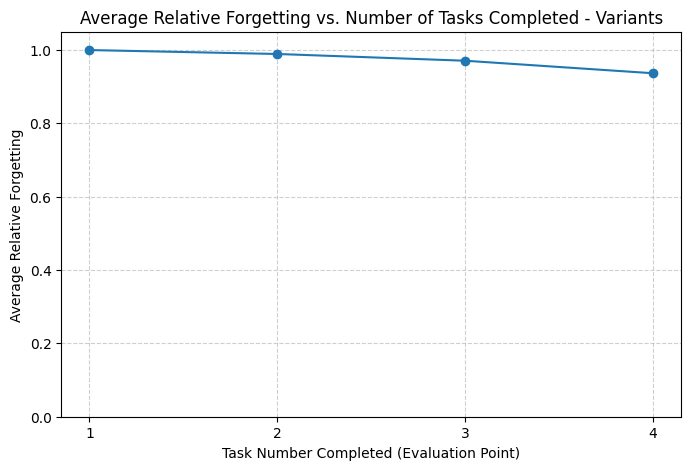

In [ ]:
viz_relative_forgetting_measure('accuracies-variants.txt', 'Variants')